In [1]:
import pandas as pd
import numpy as np
import netCDF4 as nc
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.cm as cm
import seaborn as sns
from matplotlib.colors import Normalize, rgb2hex
import matplotlib.pyplot as plt
import leafmap.maplibregl as leafmap
from shapely.geometry import Polygon
import geopandas as gpd
from plotnine import *
%matplotlib widget

In [2]:
sea_ice_df = pd.read_csv('cleaned_sea_ice_data.csv')
sea_ice_df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'cleaned_sea_ice_data.csv'

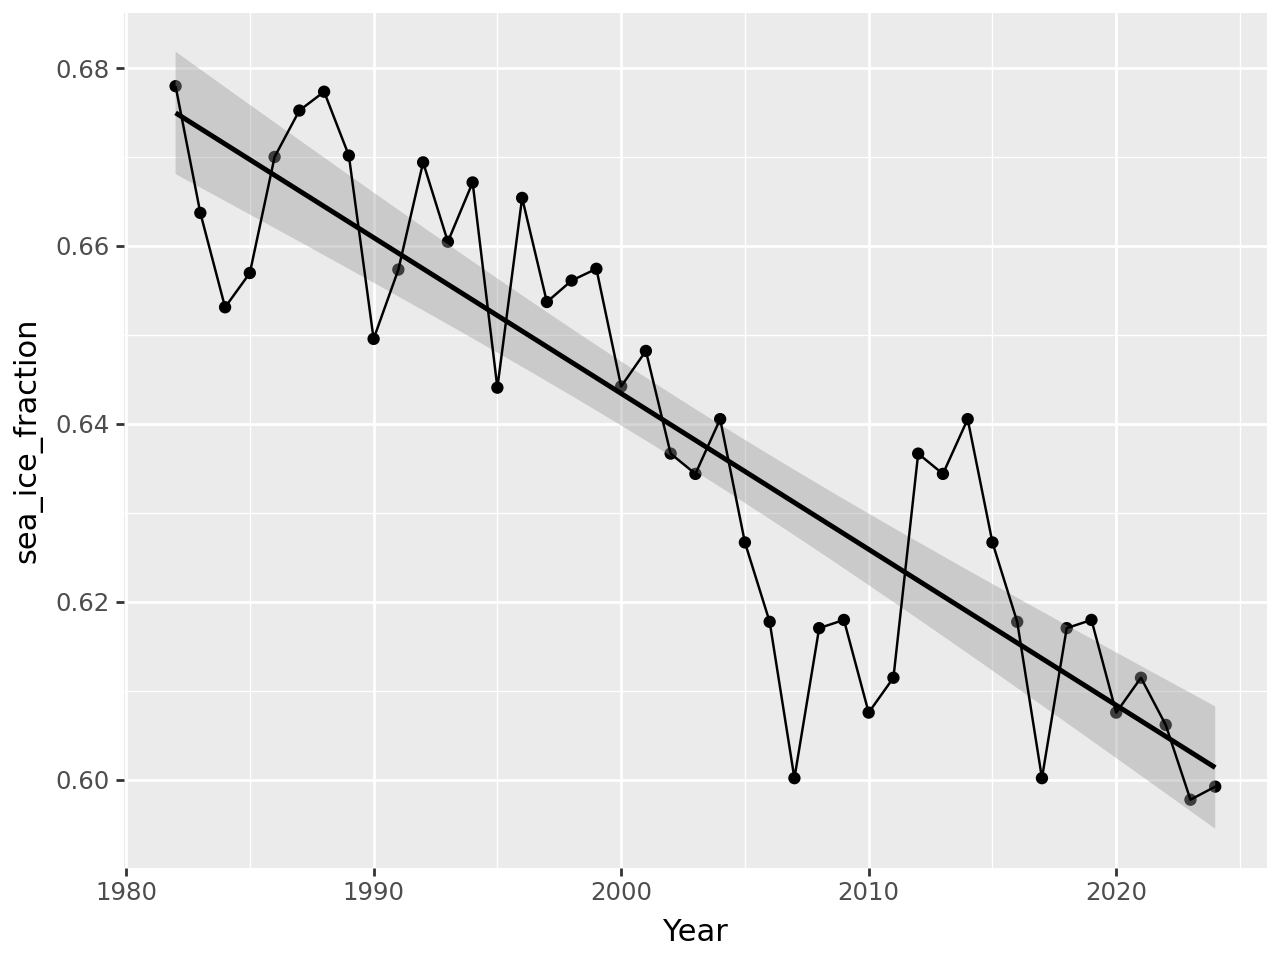

In [11]:
annual_avg = sea_ice_df.groupby('Year')[['sea_ice_fraction']].mean()
annual_avg = annual_avg.sort_values(by='sea_ice_fraction').reset_index()
ggplot(annual_avg, aes(x='Year', y='sea_ice_fraction')) + geom_point() + geom_smooth(method='lm') + geom_line()

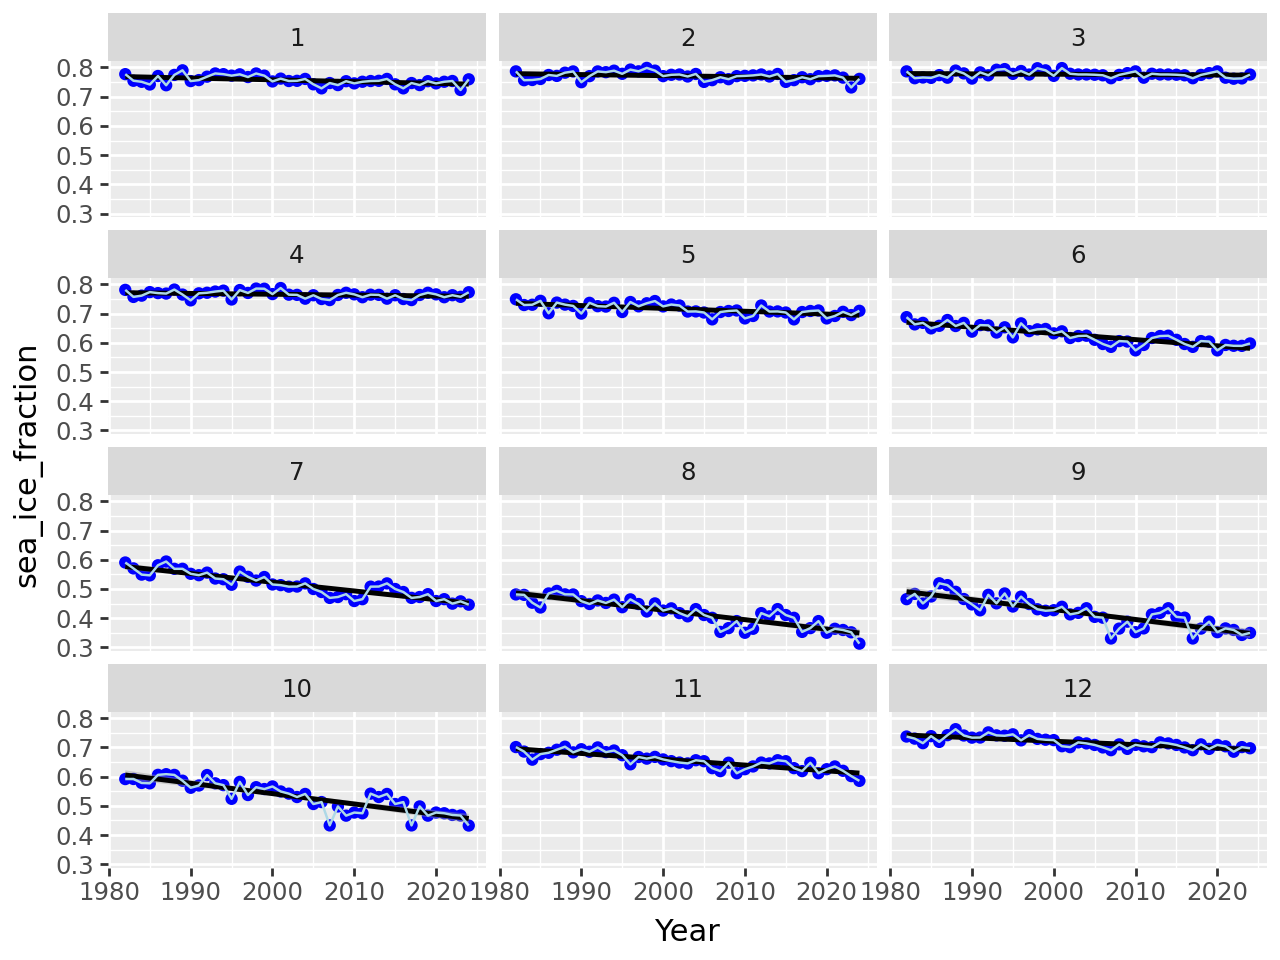

In [12]:
monthly_avg = sea_ice_df.groupby(['Year', 'MOY'])[['sea_ice_fraction']].mean()
monthly_avg = monthly_avg.reset_index()
ggplot(monthly_avg, aes(x='Year', y='sea_ice_fraction')) + facet_wrap('MOY', ncol=3) + geom_point(color='blue') + geom_smooth(method='lm') + geom_line(color='lightblue')

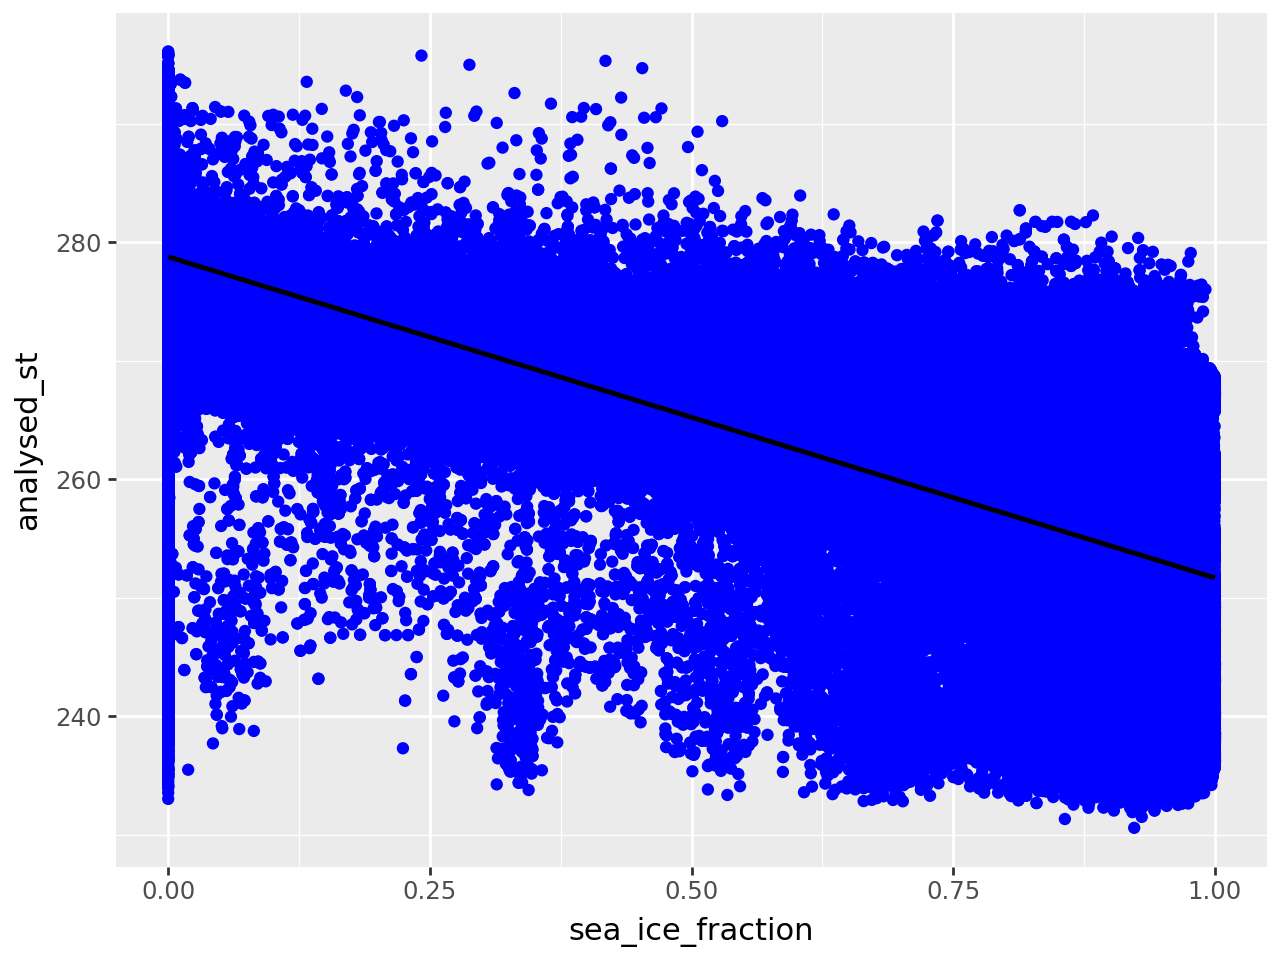

In [13]:
ggplot(sea_ice_df, aes(x='sea_ice_fraction', y='analysed_st')) + geom_point(color='blue') + geom_smooth(method='lm')

from matplotlib.widgets import Slider, Button, RadioButtons

def map_that_month(year, month='all'):
    if month == 'all':
        return sea_ice_df[sea_ice_df['Year']==year]
    return sea_ice_df[sea_ice_df['MOY']==month][sea_ice_df['Year']==year]

month=1
year=1982

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
fig.subplots_adjust(left=0.05, bottom=0.15)

mo_slider_ax  = fig.add_axes([0.05, 0.05, 0.7, 0.05], facecolor='#f0f0f0')
mo_slider = Slider(ax=mo_slider_ax, label='Month', valmin=1, valmax=12, valinit=month, valstep=1)

yr_slider_ax = fig.add_axes([0.05, 0.0, 0.7, 0.05], facecolor='#f0f0f0')
yr_slider = Slider(ax=yr_slider_ax, label='Year', valmin=1982, valmax=2024, valinit=year, valstep=1)


def update_map(val):
    current_month = int(mo_slider.val)
    current_year = int(yr_slider.val)

    filtered_gdf = sst_ice_1982_2025.loc[
        (sea_ice_df['MOY'] == current_month) & 
        (sea_ice_df['Year'] == current_year)]

    ax.clear()

    filtered_gdf.plot(facecolor=filtered_gdf['fill'], 
                      edgecolor='gray', ax=ax, linewidth=0.1)

    ax.set_title(f"Map for Month {current_month} of {current_year}")

    ax.set_xlim(0, 360)
    ax.set_ylim(58, 90)
    
    fig.canvas.draw_idle()

mo_slider.on_changed(update_map)
yr_slider.on_changed(update_map)

plt.show()

In [16]:
mapped_1982 = sea_ice_df[sea_ice_df['Year']==1982]
mapped_2023 = sea_ice_df[sea_ice_df['Year']==2023]

In [20]:
merged = pd.merge(mapped_2023, mapped_1982, on=['Long_2d', 'Lat_2d', 'geom', 'MOY'])
merged['difference'] = merged['sea_ice_fraction_y'] - merged['sea_ice_fraction_x']
merged = merged[['Long_2d', 'Lat_2d', 'MOY', 'geom', 'difference']]
merged

,Long_2d,Lat_2d,MOY,geom,difference
0,1,59,1,"POLYGON ((0 58, 0 60, 2 60, 2 58, 0 58))",0.000000
1,1,61,1,"POLYGON ((0 60, 0 62, 2 62, 2 60, 0 60))",0.001096
2,1,63,1,"POLYGON ((0 62, 0 64, 2 64, 2 62, 0 62))",-0.121322
3,1,65,1,"POLYGON ((0 64, 0 66, 2 66, 2 64, 0 64))",0.036003
4,1,67,1,"POLYGON ((0 66, 0 68, 2 68, 2 66, 0 66))",0.136440
...,...,...,...,...,...
34555,359,81,12,"POLYGON ((358 80, 358 82, 360 82, 360 80, 358 ...",-0.036934
34556,359,83,12,"POLYGON ((358 82, 358 84, 360 84, 360 82, 358 ...",-0.019394
34557,359,85,12,"POLYGON ((358 84, 358 86, 360 86, 360 84, 358 ...",-0.016777
34558,359,87,12,"POLYGON ((358 86, 358 88, 360 88, 360 86, 358 ...",-0.010007


In [22]:
cmap = plt.get_cmap('coolwarm').reversed()
norm = Normalize(vmin=merged['difference'].min(), vmax=merged['difference'].max())

merged['fill'] = merged['difference'].apply(lambda x: rgb2hex(cmap(norm(x))))
merged

,Long_2d,Lat_2d,MOY,geom,difference,fill
0,1,59,1,"POLYGON ((0 58, 0 60, 2 60, 2 58, 0 58))",0.000000,#dcdddd
1,1,61,1,"POLYGON ((0 60, 0 62, 2 62, 2 60, 0 60))",0.001096,#dcdddd
2,1,63,1,"POLYGON ((0 62, 0 64, 2 64, 2 62, 0 62))",-0.121322,#ebd3c6
3,1,65,1,"POLYGON ((0 64, 0 66, 2 66, 2 64, 0 64))",0.036003,#d7dce3
4,1,67,1,"POLYGON ((0 66, 0 68, 2 68, 2 66, 0 66))",0.136440,#c9d7f0
...,...,...,...,...,...,...
34555,359,81,12,"POLYGON ((358 80, 358 82, 360 82, 360 80, 358 ...",-0.036934,#e1dad6
34556,359,83,12,"POLYGON ((358 82, 358 84, 360 84, 360 82, 358 ...",-0.019394,#dfdbd9
34557,359,85,12,"POLYGON ((358 84, 358 86, 360 86, 360 84, 358 ...",-0.016777,#dedcdb
34558,359,87,12,"POLYGON ((358 86, 358 88, 360 88, 360 86, 358 ...",-0.010007,#dddcdc


In [34]:
merged_9 = merged[merged['MOY'] == 9]
gdf = gpd.GeoDataFrame(merged_9, geometry='geom', crs="EPSG:4326")

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf.plot(color=gdf['fill'], 
            edgecolor='gray', 
            ax=ax, 
            linewidth=0.1)
ax.set_title(f"Map for Month {current_month} of {current_year}")

str